## Задача 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### предварительный анализ (EDA)

In [80]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import random
from mlxtend.evaluate import permutation_test
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlencode
import requests

грузим данные

In [81]:
def df_YD_loader(df_url, sep = ','):
    '''Функция загружает данные с Yandex.Disk в pandas.dataframe
    принимает 2 параметра df_url - путь к файлу csv на YD и 
    sep - разделитель между данными (по умолчанию - ,)'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    df_final_url = base_url + urlencode(dict(public_key=df_url))
    response = requests.get(df_final_url)
    df_download_url = response.json()['href']
    return pd.read_csv(df_download_url, sep = sep)    

In [21]:
# информация о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
try: groupdf = df_YD_loader('https://disk.yandex.ru/d/UhyYx41rTt3clQ', sep = ';')
except KeyError: groupdf = pd.read_csv(r'../projdata/Проект_2_groups.csv', sep = ';')
groupdf.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [22]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
try: groupdopdf = df_YD_loader('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
except KeyError: groupdopdf = pd.read_csv(r'../projdata/Проект_2_group_add.csv')
groupdopdf.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [23]:
# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
try: studdf = df_YD_loader('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ')
except KeyError: studdf = pd.read_csv(r'../projdata/Проект_2_active_studs.csv')
studdf.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [24]:
studdf.shape

(8341, 1)

In [25]:
# файл с информацией об оплатах пользователей в дни проведения эксперимента
try: checkdf = df_YD_loader('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', sep = ';')
except KeyError: checkdf = pd.read_csv(r'../projdata/Проект_2_checks.csv', sep = ';')
checkdf.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [26]:
checkdf.shape

(541, 2)

пропусков во всех 4х датафреймов нет:

In [27]:
groupdf.isna().mean()

id     0.0
grp    0.0
dtype: float64

In [28]:
groupdopdf.isna().mean()

id     0.0
grp    0.0
dtype: float64

In [29]:
studdf.isna().mean()

student_id    0.0
dtype: float64

In [30]:
checkdf.isna().mean()

student_id    0.0
rev           0.0
dtype: float64

в данных о платежах и активных пользователей повторов нет:

In [31]:
print(f"к-во строк: {studdf.shape[0]}, к-во уник id: {studdf['student_id'].nunique()}")

к-во строк: 8341, к-во уник id: 8341


In [32]:
print(f"к-во строк: {checkdf.shape[0]}, к-во уник id: {checkdf['student_id'].nunique()}")

к-во строк: 541, к-во уник id: 541


In [33]:
studdf.duplicated(subset=['student_id']).sum()

0

In [34]:
checkdf.duplicated(subset=['student_id']).sum()

0

датафрейм с доп данными пользователей имеет уникальные id пользователей, которые не пересекаюся с датафреймом с основным пулом пользователей, при этом данных в доп файле меньше, чем в основном почти на 3 порядка

In [35]:
groupdf.duplicated(subset=['id']).sum()

0

In [36]:
groupdopdf.duplicated(subset=['id']).sum()

0

In [37]:
# основной датасет
print(f'''мин id {groupdf['id'].min()}, макс id {groupdf['id'].max()}, 
к-во строк {groupdf.shape[0]}, к-во уник id {groupdf['id'].nunique()}''')

мин id 1489, макс id 5694419, 
к-во строк 74484, к-во уник id 74484


In [38]:
# доп датасет
print(f'''мин id {groupdopdf['id'].min()}, макс id {groupdopdf['id'].max()}, 
к-во строк {groupdopdf.shape[0]}, к-во уник id {groupdopdf['id'].nunique()}''')

мин id 5694584, макс id 201067659, 
к-во строк 92, к-во уник id 92


#### Переходим к работе с данными

Как видно выше, датафрейм с доп данными пользователей имеет уникальные id пользователей и т.к. эти данные были зарегистрированы в ходе эксперимента (сказано, что прислали спустя 2 дня после первой передачи данных), но раз иное не оговорено - буду считать, что A/B тест продолжался дольше и нет оснований ими принебрегать. Кроме того, в данных нет меток времени и то, что часть данных поступила на 2 дня позднее вовсе не означает, того что события произошли позднее. Вполне вероятно, что это данные из другого источника / платформы или площадки с автономной базой.

Поэтому объедимим оба датафрейма пометив на всякий случай из доп потока поступили данные или нет.

Для облегчения подсчета доли группы в столбец `df['grp_dig']` вынесем цифровое представление группы (0 для A, 1 для B)

In [39]:
groupdf['dop'] = 0
groupdopdf['dop'] = 1
df = groupdf.append(groupdopdf, ignore_index=True)
df['grp_dig'] = df['grp'].apply(lambda x: 0 if x == 'A' else 1)
df.head(3)

,id,grp,dop,grp_dig
0,1489,B,0,1
1,1627,A,0,0
2,1768,B,0,1


In [40]:
# проверяем, что всё на месте
df.shape[0] == groupdf.shape[0] + groupdopdf.shape[0]

True

In [41]:
# доля доп значений во всей выборке (в %)
100 * groupdopdf.shape[0] / (groupdf.shape[0] + groupdopdf.shape[0])

0.12336408496030894

In [42]:
print(f'''сравним долю группы B в исходных значениях
по всем значениям | в первоначальн данных | в доп данных
{round(df['grp_dig'].mean(), 4):<18}{round(df[df['dop'] == 0]['grp_dig'].mean(), 4):^10}{round(df[df['dop'] == 1]['grp_dig'].mean(), 4):>22}''')

сравним долю группы B в исходных значениях
по всем значениям | в первоначальн данных | в доп данных
0.803               0.803                   0.7609


в доп данных доля группы A немного выше, но это принципиального значения не имееет, т.к. доп данных меншьше 1/8 от 1% всех 
значений.

##### замечание про дисбаланс групп
Наблюдается значительный дисбаланс в сторону группы целевой B (~ 80% пользователей), это существенный момент, т.к. как правило при A/B-тестировании наблюдается обратное соотношение, остановиммся на нём подробней. 
Наиболее оптимальным разбиением на тестовую и контрольную группу со статистической точки зрения (для наиболее точного стравнения) являятся разделение на равные выборки, однако с точки зрения бизнеса, менее затратным являяется выделение относительно небольшой части пользователей в тестовую группу, для проверки новвоведения. Однако в в данном случае, большая часть пользователей оказалась в группе для тестирования новой механике платежей.  

Могут быть различные объяснения данному факту:
1. Допущена ошибка в обозначении групп в данных и на самом деле тестовой является группа A.
2. Идёт процесс тестирования в рамках алгоритма "многорукого бандита", который предполагает постепенное увеличение веса той группы, которая показывает более эффективные результаты. И в таком случае мы обрабатываем результаты одной из стадий (не первой), когда распределение уже сдвинулось в сторону тестовой группы. (Надо отметить, что "многорукий бандит" как правило используют при выборе из множества вариантов, а не при бинарном выборе, как в нашем случае.)
3. Организация достаточно уверена в большей эффективности новой механики платежей и проводит контролирующий A/B-тест, чтобы подтвердить предположения, выделяя в контрольную группу небольшую часть пользователей.  

В описании задания нет указания какой из вариантов мог бы быть и т.к. у нас нет возможности связаться с аналитиками, планировавшими дизайн эксперимента, просто отметим в выводах, что требуется уточнение параметров тестирования, чтобы подтвердить корректность разбиения на группы и будем придериваться варианта, что ошибок нет и мы имеем дело со стандартным A/B-тестом.

Присоединим прочие данные, нас интересуют только те данные, по которым мы знаем к какой группе они относятся. Если пользователь в данный период был активен в столбце t['active'] поставим признак 1. Аналогично, если оплачивал услуги - в столбце t['is_check']. Это для простоты дальнейшего рассчёта средних

In [43]:
t = df.merge(studdf, how = 'left', left_on='id', right_on='student_id')
t['active'] = t['student_id'].apply(lambda x: 0 if pd.isna(x) else 1)
t.rename(columns={'student_id': 'act_id'}, inplace=True)
t.head()

,id,grp,dop,grp_dig,act_id,active
0,1489,B,0,1,NaN,0
1,1627,A,0,0,1627.0,1
2,1768,B,0,1,NaN,0
3,1783,B,0,1,NaN,0
4,1794,A,0,0,NaN,0


завершим присоединение данных

In [44]:
df2 = t.merge(checkdf, how = 'left', left_on='id', right_on='student_id')
df2['is_check'] = df2['student_id'].apply(lambda x: 0 if pd.isna(x) else 1)
df2.rename(columns={'student_id': 'pay_id'}, inplace=True)
df2['rev'].fillna(0, inplace=True)
df2.head()

,id,grp,dop,grp_dig,act_id,active,pay_id,rev,is_check
0,1489,B,0,1,NaN,0,NaN,0.0,0
1,1627,A,0,0,1627.0,1,1627.0,990.0,1
2,1768,B,0,1,NaN,0,NaN,0.0,0
3,1783,B,0,1,NaN,0,NaN,0.0,0
4,1794,A,0,0,NaN,0,NaN,0.0,0


Парадоксально, но у нас есть люди, которые совершили оплату, но на сайт не заходили:

In [45]:
df2[(df2['is_check'] == 1) & (df2['active'] == 0)].shape[0]

149

И их больше четверти всех оплативших:

In [46]:
df2[(df2['is_check'] == 1) & (df2['active'] == 0)].shape[0] / df2[(df2['is_check'] == 1)].shape[0]

0.2754158964879852

Видимо существуют ещё какие-то механизмы оплаты наших услуг (в мобильном приложении и/или офлайн в офисе), при том, что база всех пользователей общая. Важно то, что те, кто совершил оплату, но на сайт не заходил - не видели и не взимодействовали с новой механикой оплаты услуг. Значит надо отфильтровать данные для обработки оставив из оплативших только "активных" пользователей - тех, кто заходил на сайт.

Поэтому мы сначала присоединим к датафрейму активных пользователей, датафрейм с оплатившими пользователями (которые являются также активными): 

In [47]:
checkdf = checkdf.rename(columns={'student_id': 'pay_id'})
t2 = studdf.merge(checkdf, how = 'left', left_on='student_id', right_on='pay_id')
t2['rev'].fillna(0, inplace=True)
t2.head(3)

,student_id,pay_id,rev
0,581585,NaN,0.0
1,5723133,NaN,0.0
2,3276743,NaN,0.0


и теперь соединим с данными о разбивке пользователей на группы:

In [48]:
df = df.merge(t2, how = 'left', left_on='id', right_on='student_id')
df['active'] = df['student_id'].apply(lambda x: 0 if pd.isna(x) else 1)
df['is_check'] = df['pay_id'].apply(lambda x: 0 if pd.isna(x) else 1)
df.rename(columns={'student_id': 'act_id'}, inplace=True)
df.head(3)

,id,grp,dop,grp_dig,act_id,pay_id,rev,active,is_check
0,1489,B,0,1,NaN,NaN,NaN,0,0
1,1627,A,0,0,1627.0,1627.0,990.0,1,1
2,1768,B,0,1,NaN,NaN,NaN,0,0


In [49]:
# Прверим не было ти в данных об активных и платящих пользователей записей по которым у нас нет данных о принадлежности к 
# группам тестирования. Таких нет:
print(f"активных без группы: {studdf.merge(df, how = 'left', left_on='student_id', right_on='id')['grp'].isna().sum()}", 
     f"платящих без группы: {checkdf.merge(df, how = 'left', left_on='pay_id', right_on='id')['grp'].isna().sum()}", sep = '\n')

активных без группы: 0
платящих без группы: 0


In [50]:
# глядя на этот сэмпл данных может возникнуть иллюзия, что есть какая-то зависимость между расходами пользователя и его id
df[df['is_check'] == 1][['id', 'grp', 'dop', 'rev']]

,id,grp,dop,rev
1,1627,A,0,990.0000
220,100300,B,0,990.0000
320,108270,B,0,290.0000
3779,264473,B,0,1900.0001
4187,274352,B,0,690.0000
...,...,...,...,...
74365,5645737,B,0,1900.0000
74381,5651566,B,0,1900.0000
74402,5662322,B,0,1900.0000
74452,5681918,B,0,1900.0000


<Figure size 720x720 with 0 Axes>

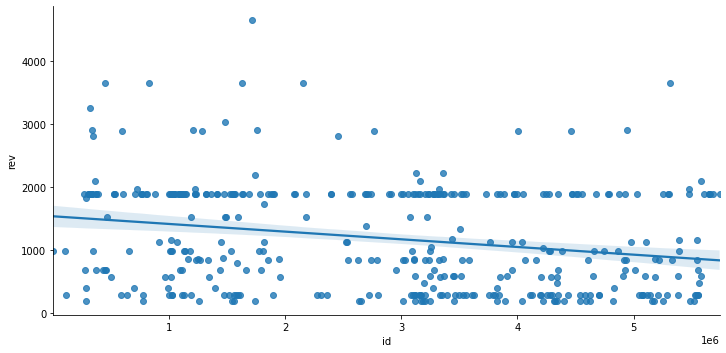

In [51]:
# убедимся, что это совсем не так:
tt = df[df['rev'] > 0]
plt.figure(figsize=(10, 10))
sns.lmplot(data=tt, x='id', y='rev', aspect=2);

##### выбор метрик
Тест был задуман, для применения новой механики оплаты услуг на сайте, но механизм оплаты на сайте никак не может оказать влияние на привлечение пользователей на сайт. Поэтому надо оценить изменение метрик пользователей, посетивших сайт, значит будем оценивать изменение следующих метрик: 
- конверсия активных пользователей в платящих пользователей (CR_pay_act) 
- средний чек на активного пользователя (ARPAU)
- среднем чеке на платящего пользователя (ARPPU)

Первая показывает, сколько пользователй побывавших на сайте в итоге совершили платежи, вторая - как изменился средний платёж на одного пользователя сайта и следовательно как изменится общий доход пользователей сайта при использовании новой механике оплаты, а последняя - как изменился средний платёж на одного платящего пользователя. Нам детали изменений оплаты услуг не известны, но вполне может быть, что помимо облегчения самомго процесса совершения оплаты, также используются к примеру в более удобном виде предложения субпродуктов / допуслуг, поэтому новая механика может оказывать влияние как конверсию, так и на стредний чек. 

В случае, если тестирование покажет положительный результат, можно будет провести рекламную компанию или оповещение по всем каналам о новой механике платежей, чтобы увеличить конверсию всех пользователей в активных пользователей (и повысить т.о. средний чек на пользователя ARPU), но сама механика оплаты услуг на сайте на данном этапе на эти две метрики влияние не оказывает.

сгруппируем данные по группам и посчитаем метрики

In [52]:
df_by_gr = df.groupby('grp', as_index = False). \
           agg(grp_dig = ('grp_dig', 'mean'), 
               act_count = ('act_id', 'count'), 
               pay_count = ('pay_id', 'count'), 
               rev_sum = ('rev', 'sum'))
df_by_gr['CR_pay_act'] = df_by_gr['pay_count'] / df_by_gr['act_count']
df_by_gr['ARPAU'] = df_by_gr['rev_sum'] / df_by_gr['act_count']
df_by_gr['ARPPU'] = df_by_gr['rev_sum'] / df_by_gr['pay_count']
df_by_gr

,grp,grp_dig,act_count,pay_count,rev_sum,CR_pay_act,ARPAU,ARPPU
0,A,0,1538,78,72820.0000,0.050715,47.347204,933.589744
1,B,1,6803,314,394974.0035,0.046156,58.058798,1257.878992


Столбцы act_count, pay_count, rev_sum приведены здесь для информации и означают соответственно количество активных пользователей, количество пользователей, совершивших платежи и общие продажи по группе.

Метрики показывают разнонаправленные тренды: конверсия активных в платящих пользователей немного ухудшидась в целевой группе (B), а метрики со средниими чеками улучшились.

Представим изменения отобранных метрик в более удобном (транспонированном) виде. 

Видим, что конверсия снизилась почти на 9%, но средние чеки возросли на 22-35%. Теперь надо установить значимость изменений

In [53]:
df_by_gr2 = df_by_gr[['grp', 'CR_pay_act', 'ARPAU', 'ARPPU']]
df_by_gr2.set_index('grp', inplace=True)
df_by_gr2 = df_by_gr2.T
df_by_gr2['delta'] = df_by_gr2['B'] - df_by_gr2['A']
df_by_gr2['chng'] = df_by_gr2['B'] / df_by_gr2['A']
df_by_gr2

grp,A,B,delta,chng
CR_pay_act,0.050715,0.046156,-0.004559,0.910104
ARPAU,47.347204,58.058798,10.711594,1.226235
ARPPU,933.589744,1257.878992,324.289248,1.347357


определим значимость изменений для каждой выбранной метрики

#### 1. Конверсия активных пользователей в платящих пользователей (CR_pay_act)

для CR_pay_act нулевая гипотеза будет означать, что CR_pay_act для групп B и A значимо не отличаются, альтернативная - что отличаются

Для проверки используем статистику хи-квадрат. 

Построим таблицу сопряжённости, где в столбцах будут неплатящие и платящие клиенты соответствующей группы:

In [54]:
actdf = df[df['active'] == 1]
CRcross = pd.crosstab(actdf['grp'], actdf['is_check'])
CRcross

is_check,0,1
grp,,
A,1460,78
B,6489,314


In [55]:
# применим критетий хи-квадрат
ss.chi2_contingency(CRcross)

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

In [56]:
print('различия не значимы' if ss.chi2_contingency(CRcross)[1] >= 0.05 else 'различия значимы')

различия не значимы


Нет оснований отвергнуть нулевую гипотезу о том, что конверсии активных пользователей в платежи для этих групп не отличаются

Учитывая значительный дисбалансс групп в пользу тестовой (B), проведём также оценку с использованием взвешивания данных

In [57]:
# таблица сопряжённости с учётом весовой поправки 
corrwgs = len(df[df['grp'] == 'A']) / len(df[df['grp'] == 'B']) # весовая поправка 
CRcross_ = CRcross.copy()
CRcross_.loc['B'] *= corrwgs
CRcross_
# видно, что при поправке количество платящих отличается всего на 1, но посмотрим на результаты

is_check,0,1
grp,,
A,1460.000000,78.000000
B,1592.152648,77.043602


In [58]:
# применим критетий хи-квадрат
ss.chi2_contingency(CRcross_)

(0.26933967984943796,
 0.6037750648739049,
 1,
 array([[1463.64937071,   74.35062929],
        [1588.50327695,   80.6929724 ]]))

In [59]:
print('различия не значимы' if ss.chi2_contingency(CRcross_)[1] >= 0.05 else 'различия значимы')

различия не значимы


да, результат не изменился, нет оснований отвергнуть нулевую гипотезу о том, что конверсии в платежи для этих групп не отличаются

Отмечу также, что изменение (увеличение) конверсии всех пользователей в пользователей совершившивших покупки, так же не являятся значимым:

In [60]:
print('различия не значимы' if ss.chi2_contingency(pd.crosstab(df['grp'], df['is_check']))[1] >= 0.05 else 'различия значимы')

различия не значимы


А вот изменение (снижение) конверсии всех пользователей, в пользователей посещаюх сайт значимо. Однако, как указал выше предмет исследования (новая механика платежей) на этот параметр не влияет. Все пользователи уникальные, поэтому здесь нет ситуации, когда пользователь пришёл на сайт, посмотрел на механику платежей, ушёл и оплатил как-то иначе. Данных об инфоканале между нашими пользователями тоже нет (есть подозрение, что наш сервис - LMS, а пользователи - студенты, но строго говоря об этом в задании 1 не говорится, но даже если это так, это ещё не означает, что все они состоят едином коммюнити).

In [61]:
print('различия не значимы' if ss.chi2_contingency(pd.crosstab(df['grp'], df['active']))[1] >= 0.05 else 'различия значимы')

различия значимы


#### 2. средний чек на активного пользователя (ARPAU)

для ARPAU нулевая гипотеза будет означать, что ARPAU для групп B и A значимо не отличаются, альтернативная - что отличаются

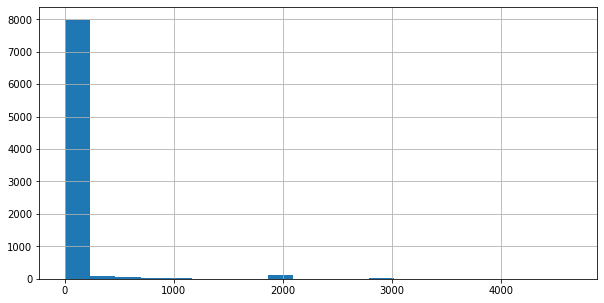

In [62]:
# посмотрим на распределение чеков для  активных пользователей - конечно нормальным оно не выглядит
plt.figure(figsize=(10, 5))
actdf['rev'].hist(bins = 20);

In [63]:
# Выделение данных для каждой группы
ARPAU_A = df[(df['grp'] == 'A') & (df['active'] == 1)]['rev']
ARPAU_B = df[(df['grp'] == 'B') & (df['active'] == 1)]['rev']

In [64]:
# и предсказуемо таковым не является (тест на нормальность Пирсона-Д'Агостино), но данных достаточно много, чтобы можно было 
# проверить t-тестом
print('p-value для A', 'p-value для B', sep = '\t')
print(ss.normaltest(ARPAU_A)[1], ss.normaltest(ARPAU_B)[1], sep = '\t\t')

p-value для A	p-value для B
0.0		0.0


In [65]:
# Проведение t-теста для несбалансированных выборок
ss.ttest_ind(ARPAU_A, ARPAU_B, equal_var=False)

Ttest_indResult(statistic=-1.286373849379703, pvalue=0.19843583641451018)

In [66]:
# Вывод результатов
print('различия не значимы' if ss.ttest_ind(ARPAU_A, ARPAU_B, equal_var=False)[1] >= 0.05 else 'различия значимы')

различия не значимы


p-value гораздо больше 0.05, нет оснований отклонить нулевую гипотезу и считать, что средний чек на активного пользователя значимо изменился в тестовой группе

#### 3. средний чек на платящего пользователя (ARPPU)

для ARPPU нулевая гипотеза будет означать, что ARPPU для групп B и A значимо не отличаются, альтернативная - что отличаются

In [67]:
# Выделение данных (платящих пользователей) для каждой группы 
ARPPU_A = df[(df['grp'] == 'A') & (df['is_check'] == 1)]['rev']
ARPPU_B = df[(df['grp'] == 'B') & (df['is_check'] == 1)]['rev']

In [68]:
type(ARPPU_A)

pandas.core.series.Series

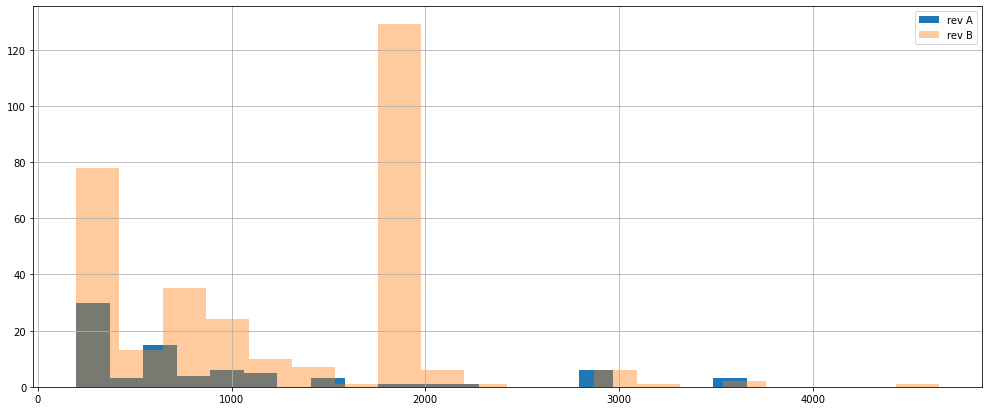

In [69]:
# здесь конечно тоже распределения нормальными не выглядят. Пользуясь случаем отметим по гистограмме, что хотя диапазон 
# значений чеков в обеих группах близкий, но в целевой группе (В) есть 2 явных всплеска - значения до 1000 и около 1800, в 
# контрольной группе (A) - только до 1000 (да, мы тут учитываем, что график для A д.б. примерно в 4 раза выше из-за дисбаланса).
# Т.е. в контрольной группе относительно мало средних чеков.
plt.figure(figsize=(17, 7))
ARPPU_A.hist(bins = 20, label='rev A')
ARPPU_B.hist(bins = 20, label='rev B', alpha=0.4);
plt.legend();

In [70]:
# проверяем - и предсказуемо распределение нормальным не является (тест Шапиро)
print(f'для А {ss.shapiro(ARPPU_A)[1]}', f'для В {ss.shapiro(ARPPU_B)[1]}', sep = '\n')

для А 1.4986822893803264e-10
для В 1.5437024585965894e-16


In [71]:
# посмотрим сколько у нас платящих клиентов
print('A', 'B', sep = '\t')
print(df[(df['grp'] == 'A') & (df['is_check'] == 1)].shape[0], 
      df[(df['grp'] == 'B') & (df['is_check'] == 1)].shape[0], sep = '\t')

A	B
78	314


наблюдений в принципе больше 30 но не слишком, поэтому здесь применим бутстреп

In [72]:
# применяем бутстреп
ARPPU_A_ar = ARPPU_A.values
ARPPU_B_ar = ARPPU_B.values
bsres_A_ = ss.bootstrap((ARPPU_A_ar, ), np.mean, n_resamples=15000)
bsres_B_ = ss.bootstrap((ARPPU_B_ar, ), np.mean, n_resamples=15000)
print(f'для выборки А {bsres_A_.confidence_interval}', f'для выборки В {bsres_B_.confidence_interval}', sep = '\n')

для выборки А ConfidenceInterval(low=754.9358974358975, high=1168.993379814125)
для выборки В ConfidenceInterval(low=1172.7629493957163, high=1347.9516754733695)


In [73]:
print(f'стнд ошибка для выборки А {bsres_A_.standard_error}', f'стнд ошибка для выборки В {bsres_B_.standard_error}', sep ='\n')

стнд ошибка для выборки А 103.85047899254339
стнд ошибка для выборки В 44.60395875605886


интервалы средних не пересекаются (хотя и с минимальной разницой), значит можно сделать вывод о не слишком уверенной значимостьи различий ARPPU, в том смысле, что средний чек на платящего пользователя при новом механизмеплатежей увеличился, основную гипотезу отклоняем

##### замечание про моды групп

На гистограмме ниже, я показываю в чём существенная разница в распределении чеков групп A и B (масштаб гистограммы для группы А искусственно увеличен, так, чтобы нивелировать дисбаланс наблюдений): в контрольной группе (B) относительно целевой (A) наиболее распростаненными были чеки с суммой близкой к минимальной 290, а в целелевой наиболее расростаненными были 1900 (ещё на ячейку ниже представлены характеристики чеков для платящих пользователей по группам).   
Группе разработчиков механики оплаты услуг на сайте надо проверить чем вызван всплеск оплат за 1900 в тестовой группе и связано ли это с новой механикой: в последующих двух ячейках можно убедится, что услуга за 290 есть и в тестовой группе (с новой механикой) и в контрольной группе (с базовой механикой), а вот в контрольной группе услуги за 1900 (и 1900.0001) не выбрал никто, возможно этой популярной услуги вообще не было в базовой механике платежей и это и есть причина роста среднего чека как вариант. Если же услуга за 1900 (и 1900.0001) была и в базовой механике, но в группу A были отобраны пользователи, которые по каккой-то причине ей не могут воспользоваться независимо от мехники платежей - то это ошибка разбиения на группы, т.к. группы получаются не одинаковы по структуре. В условии денежные единицы не указаны, поэтому нет оснований видеть ошибку или неточность в размерности услуги за 1900.0001, возможно это какая-то криптовалюта, для которой это вполне корректная дробная часть.

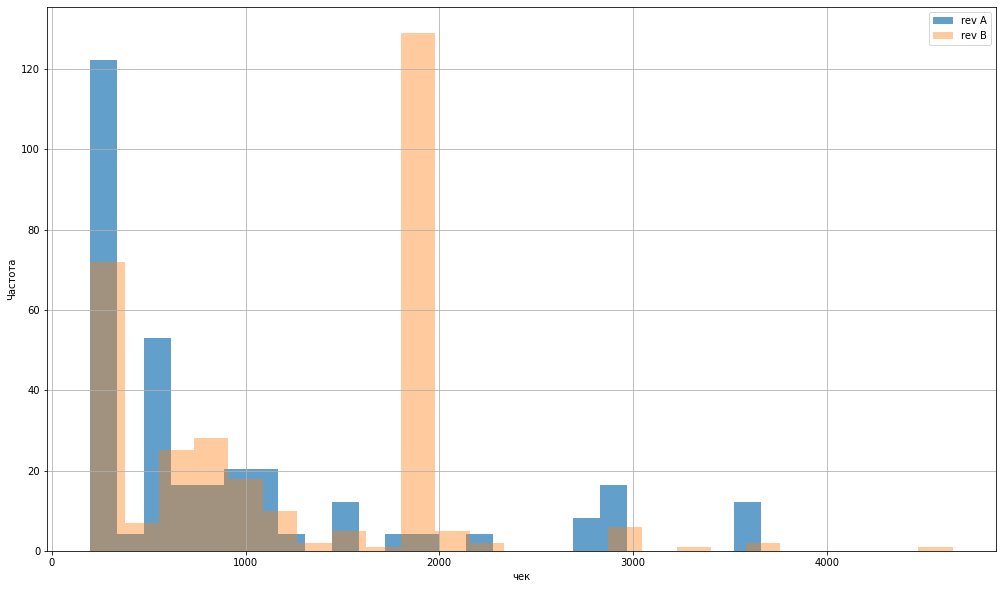

In [74]:
plt.figure(figsize=(17, 10))
# вес для отображения распределений в одном масштабе:
weights_A = np.ones_like(ARPPU_A) * (len(df[df['grp'] == 'B']) / len(df[df['grp'] == 'A'])) 
ARPPU_A.hist(bins = 25, label='rev A', alpha=0.7, weights=weights_A)
ARPPU_B.hist(bins = 25, label='rev B', alpha=0.4);
plt.xlabel('чек')
plt.ylabel('Частота')
plt.legend();

In [75]:
# центральные характеристики чеков для платящих пользователей: средняя, медиана, мода, минмум и максимум
df[df['is_check'] == 1].groupby('grp', as_index = False). \
    agg(check_mean = ('rev', 'mean'), check_median = ('rev', 'median'), check_mode=('rev', lambda x: x.mode().iloc[0]),
       check_min = ('rev', 'min'), check_max = ('rev', 'max'))

,grp,check_mean,check_median,check_mode,check_min,check_max
0,A,933.589744,585.0,290.0,199.0,3660.0
1,B,1257.878992,1140.0,1900.0,199.0,4650.0


In [76]:
# стоимость услуг в группе A по убыванию количества покупок, видно, что здесь нет 1900.0000 и 1900.0001
ARPPU_A.value_counts()

290.0     25
580.0      6
990.0      5
590.0      5
199.0      5
690.0      4
840.0      3
3660.0     3
1530.0     3
1160.0     2
1140.0     2
2820.0     2
489.0      2
2910.0     2
2900.0     1
1830.0     1
2220.0     1
1980.0     1
870.0      1
398.0      1
2890.0     1
1180.0     1
1039.0     1
Name: rev, dtype: int64

In [77]:
# стоимость услуг в группе B по убыванию количества покупок
ARPPU_B.value_counts()

1900.0000    93
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
1530.0000     5
580.0000      5
870.0000      5
2099.0000     3
2890.0000     3
1980.0000     2
2910.0000     2
3660.0000     2
1968.0000     1
880.0000      1
3040.0000     1
796.0000      1
2190.0000     1
1160.0000     1
1729.0000     1
2220.0000     1
4650.0000     1
1339.0000     1
1388.0000     1
489.0000      1
3260.0000     1
1050.0000     1
597.0000      1
Name: rev, dtype: int64

In [78]:
# ещё раз отдельно - услуги (и их частота) из группы A, которых нет в группе B
ARPPU_A[ARPPU_A.isin(ARPPU_A[~ARPPU_A.isin(ARPPU_B)].unique())].value_counts()

2820.0    2
1039.0    1
1180.0    1
2900.0    1
1830.0    1
Name: rev, dtype: int64

In [79]:
# здесь - услуги (и их частота) из группы B, которых нет в группе A. Хорошо видно, что услуги за 1900 и 1900.0001 очень 
# выделяются по частоте
ARPPU_B[ARPPU_B.isin(ARPPU_B[~ARPPU_B.isin(ARPPU_A)].unique())].value_counts()

1900.0000    93
1900.0001    35
2099.0000     3
2190.0000     1
4650.0000     1
597.0000      1
1050.0000     1
1339.0000     1
3260.0000     1
1729.0000     1
1968.0000     1
1388.0000     1
796.0000      1
3040.0000     1
880.0000      1
Name: rev, dtype: int64

#### Выводы

Как показали результаты тестов, при применении новой механики платежей изменения конверсии активных пользователей в пользователей совершивших покупки и среднего чека на антивных пользователей значимыми не являются, но изменение (увеличение) чека на платящих пользователей значимо.   

Можно порекомендовать группе реализовывающей AB-тест проверить корректоность разбиения пользователей на группы (см. выше замечание про дисбаланс групп) и проверить то, что появление услуг за 1900 и 1900.0001 в целевой группе B связано с внедрением новой механики оплаты услуг на сайте (см. выше замечание про моды групп). В случае если всё верно - можно рекомендовать внедрение новой механики оплаты услуг на сайте на всех пользователей, т.к. она увеличивает средний чек на платещего пользователя (ARPPU) за счёт предпочтения более дорогих услуг.